In [ ]:
from google.cloud import vision
import os
import io
from PIL import Image, ImageDraw, ImageFilter
import matplotlib.pyplot as plt
import numpy as np

# 환경변수 설정
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'google.json'

def apply_mosaic(image, bbox, intensity=10):
    """지정된 바운딩 박스 영역에 모자이크 효과 적용"""
    x1, y1, x2, y2 = bbox
    
    # 영역 추출
    region = image.crop((x1, y1, x2, y2))
    
    # 모자이크 효과 (픽셀화)
    width, height = region.size
    small = region.resize((width // intensity, height // intensity), Image.NEAREST)
    mosaic = small.resize((width, height), Image.NEAREST)
    
    # 원본 이미지에 모자이크 영역 붙이기
    image.paste(mosaic, (x1, y1))
    
    return image

def find_text_and_get_right_area(annotations, target_text, image_width, margin=10):
    """특정 텍스트를 찾고 그 오른쪽 영역의 바운딩 박스 반환"""
    for annotation in annotations:
        if target_text in annotation.description:
            vertices = annotation.bounding_poly.vertices
            
            # 텍스트 바운딩 박스 좌표
            x_coords = [vertex.x for vertex in vertices]
            y_coords = [vertex.y for vertex in vertices]
            
            text_x1 = min(x_coords)
            text_y1 = min(y_coords)
            text_x2 = max(x_coords)
            text_y2 = max(y_coords)
            
            # 오른쪽 영역 계산 (텍스트 끝부터 이미지 끝까지)
            right_x1 = text_x2 + margin
            right_y1 = text_y1
            right_x2 = image_width
            right_y2 = text_y2
            
            return (right_x1, right_y1, right_x2, right_y2)
    
    return None

image_path = "proof/hoshi2.png"
    
print("한글 OCR 처리 중...")

# 클라이언트 초기화
client = vision.ImageAnnotatorClient()

# 이미지 로드
with io.open(image_path, 'rb') as image_file:
    content = image_file.read()

image = vision.Image(content=content)

# 한국어 우선 설정
image_context = vision.ImageContext(language_hints=['ko'])

# 텍스트 감지
response = client.text_detection(image=image, image_context=image_context)

# 원본 이미지 로드
img = Image.open(image_path).convert("RGB")
image_width, image_height = img.size

# 모자이크 처리할 텍스트들
target_texts = ['열', '2025년', '예약번호']

print("감지된 텍스트들:")
for i, annotation in enumerate(response.text_annotations):
    print(f"{i}: {annotation.description}")

# 각 타겟 텍스트에 대해 오른쪽 영역 모자이크 처리
for target_text in target_texts:
    right_area = find_text_and_get_right_area(response.text_annotations, target_text, image_width)
    
    if right_area:
        print(f"'{target_text}' 텍스트 발견! 오른쪽 영역 모자이크 처리: {right_area}")
        img = apply_mosaic(img, right_area, intensity=15)
    else:
        print(f"'{target_text}' 텍스트를 찾을 수 없습니다.")

# 바운딩 박스 그리기 (선택사항)
draw = ImageDraw.Draw(img)

# 모든 텍스트 바운딩 박스 표시 (디버깅용)
for annotation in response.text_annotations[1:]:
    vertices = annotation.bounding_poly.vertices
    draw.polygon([(vertex.x, vertex.y) for vertex in vertices], outline='blue', width=1)

# 이미지 출력
plt.figure(figsize=(12, 10))
plt.imshow(img)
plt.axis('off')
plt.title('모자이크 처리된 이미지')
plt.show()

# 처리된 이미지 저장
output_path = "proof/hoshi2_mosaic.png"
img.save(output_path)
print(f"모자이크 처리된 이미지 저장: {output_path}")

# 전체 텍스트 출력
print("\n=== 전체 감지된 텍스트 ===")
if response.text_annotations:
    print(response.text_annotations[0].description)
else:
    print("텍스트를 감지할 수 없습니다.")

한글 OCR 처리 중...


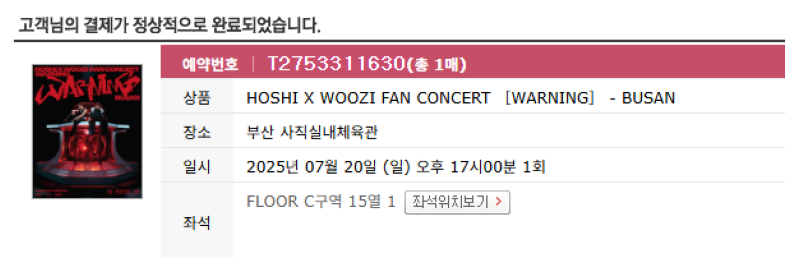

'고객님의 결제가 정상적으로 완료되었습니다.\n예약번호 | T2753311630(총 1매)\nWARNIN\n상품\nHOSHI X WOOZI FAN CONCERT [WARNING] - BUSAN\n장소\n부산 사직실내체육관\n일시\n좌석\n2025년 07월 20일 (일) 오후 17시00분 1회\nFLOOR C구역 15일 1 좌석위치보기>'

In [ ]:
from google.cloud import vision
import os
import io
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# 환경변수 설정
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'google.json'

image_path = "proof/hoshi2.png"
    
print("한글 OCR 처리 중...")

"""간단한 한글 OCR 함수"""
# 클라이언트 초기화
client = vision.ImageAnnotatorClient()

# 이미지 로드
with io.open(image_path, 'rb') as image_file:
    content = image_file.read()

image = vision.Image(content=content)

# 한국어 우선 설정
image_context = vision.ImageContext(language_hints=['ko'])

# 텍스트 감지
response = client.text_detection(image=image, image_context=image_context)

# 바운딩 박스 그리기
img = Image.open(image_path).convert("RGB")
draw = ImageDraw.Draw(img)

for annotation in response.text_annotations[1:]:
    vertices = annotation.bounding_poly.vertices
    draw.polygon([(vertex.x, vertex.y) for vertex in vertices], outline='red')

# 이미지 출력
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

# 결과 반환
response.text_annotations[0].description


In [7]:
response

text_annotations {
  locale: "ko"
  description: "고객님의 결제가 정상적으로 완료되었습니다.\n예약번호 | T2753311630(총 1매)\nWARNIN\n상품\nHOSHI X WOOZI FAN CONCERT [WARNING] - BUSAN\n장소\n부산 사직실내체육관\n일시\n좌석\n2025년 07월 20일 (일) 오후 17시00분 1회\nFLOOR C구역 15일 1 좌석위치보기>"
  bounding_poly {
    vertices {
      x: 6
      y: 6
    }
    vertices {
      x: 519
      y: 6
    }
    vertices {
      x: 519
      y: 173
    }
    vertices {
      x: 6
      y: 173
    }
  }
}
text_annotations {
  description: "고객님"
  bounding_poly {
    vertices {
      x: 6
      y: 6
    }
    vertices {
      x: 41
      y: 6
    }
    vertices {
      x: 41
      y: 19
    }
    vertices {
      x: 6
      y: 19
    }
  }
}
text_annotations {
  description: "의"
  bounding_poly {
    vertices {
      x: 43
      y: 6
    }
    vertices {
      x: 53
      y: 6
    }
    vertices {
      x: 53
      y: 19
    }
    vertices {
      x: 43
      y: 19
    }
  }
}
text_annotations {
  description: "결제"
  bounding_poly {
    vertices {
     

In [3]:
from google.cloud import vision
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import io
import os

# 환경변수 설정 (코드에서 직접 설정)
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'google.json'

# Google Vision API 클라이언트 초기화
client = vision.ImageAnnotatorClient()

# 이미지 로드 및 준비
img_path = "proof/hoshi2.png"
image = Image.open(img_path).convert("RGB")
masked_image = image.copy()
draw = ImageDraw.Draw(masked_image)

# 이미지를 바이트로 변환하여 Google Vision API에 전달
with io.open(img_path, 'rb') as image_file:
    content = image_file.read()

vision_image = vision.Image(content=content)

# 텍스트 감지 실행
response = client.text_detection(image=vision_image)
annotations = response.text_annotations

if response.error.message:
    raise Exception(f'{response.error.message}')

def get_center(vertices):
    """Google Vision의 vertices에서 중심점 계산"""
    x = sum(vertex.x for vertex in vertices) / len(vertices)
    y = sum(vertex.y for vertex in vertices) / len(vertices)
    return x, y

def vertices_to_coords(vertices):
    """Google Vision의 vertices를 좌표 리스트로 변환"""
    return [(vertex.x, vertex.y) for vertex in vertices]

# 첫 번째 annotation은 전체 텍스트이므로 제외하고 개별 단어들만 처리
lines = []
if annotations:
    for annotation in annotations[1:]:  # 첫 번째는 전체 텍스트
        coords = vertices_to_coords(annotation.bounding_poly.vertices)
        text = annotation.description
        lines.append([coords, [text, 0.0]])  # PaddleOCR 형식에 맞춤

# 번호 줄 찾기 → 한 줄 전체 마스킹
y_targets = [get_center(line[0]) for line in lines if '번호' in line[1][0]]
y_targets = [y for x, y in y_targets]

if y_targets:
    masked_coords = []
    for line in lines:
        if '번호' not in line[1][0]:
            x_center, y_center = get_center(line[0])
            if any(abs(y_center - y) < 10 for y in y_targets):
                masked_coords.extend(line[0])
    
    if masked_coords:
        x_min = min(p[0] for p in masked_coords)
        y_min = min(p[1] for p in masked_coords)
        x_max = max(p[0] for p in masked_coords)
        y_max = max(p[1] for p in masked_coords)
        draw.rectangle([(x_min, y_min), (x_max, y_max)], fill="gray")

# 2025년 오른쪽 전체, 좌석 왼쪽 하나만 마스킹
for idx, line in enumerate(lines):
    coords, text = line[0], line[1][0]
    x_center, y_center = get_center(coords)

    if '2025년' in text:
        # 같은 줄 오른쪽 단어 전체 박스 계산
        box_coords = []
        for other in lines:
            other_x, other_y = get_center(other[0])
            if abs(other_y - y_center) < 20 and other_x > x_center:
                box_coords.extend(other[0])
        
        if box_coords:
            x_min = min(p[0] for p in box_coords)
            y_min = min(p[1] for p in box_coords)
            x_max = max(p[0] for p in box_coords)
            y_max = max(p[1] for p in box_coords)
            draw.rectangle([(x_min, y_min), (x_max, y_max)], fill="gray")

    elif '좌석' in text:
        # 같은 줄 왼쪽 하나만
        for prev in reversed(lines[:idx]):
            px, py = get_center(prev[0])
            if abs(py - y_center) < 20 and px < x_center:
                x_min = min(p[0] for p in prev[0])
                y_min = min(p[1] for p in prev[0])
                x_max = max(p[0] for p in prev[0])
                y_max = max(p[1] for p in prev[0])
                draw.rectangle([(x_min-1, y_min-1), (x_max+1, y_max+1)], fill="gray")
                break

# 전체 텍스트 출력 (Google Vision의 첫 번째 annotation이 전체 텍스트)
if annotations:
    all_text = annotations[0].description
    print("\n=== 전체 텍스트 ===")
    print(all_text)

# 개별 단어들도 출력 (디버깅용)
print("\n=== 개별 단어들 ===")
for line in lines:
    print(f"텍스트: {line[1][0]}, 중심점: {get_center(line[0])}")

# 결과 이미지 출력
plt.figure(figsize=(10, 10))
plt.imshow(masked_image)
plt.axis('off')
plt.show()

AttributeError: 'tuple' object has no attribute 'x'

In [ ]:
from paddleocr import PaddleOCR
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np

# OCR 세팅
ocr = PaddleOCR(
    text_detection_model_name="PP-OCRv5_server_det",
    text_recognition_model_name="PP-OCRv5_server_rec",
    lang='korean',
    use_angle_cls=True,
    det_limit_side_len=1280,
    drop_score=0.3
)

# 이미지 로드 및 준비
img_path = "proof/hoshi2.png"
image = Image.open(img_path).convert("RGB")
masked_image = image.copy()
draw = ImageDraw.Draw(masked_image)

# OCR 실행
ocr_result = ocr.ocr(img_path, cls=True)
lines = ocr_result[0] if ocr_result and ocr_result[0] else []

def get_center(coords):
    x = np.mean([p[0] for p in coords])
    y = np.mean([p[1] for p in coords])
    return x, y

# 번호 줄 찾기 → 한 줄 전체 마스킹
y_targets = [get_center(line[0])[1] for line in lines if '번호' in line[1][0]]

if y_targets:
    masked_coords = [p for line in lines 
                     if '번호' not in line[1][0] 
                     and any(abs(get_center(line[0])[1] - y) < 10 for y in y_targets)
                     for p in line[0]]
    if masked_coords:
        x_min = min(p[0] for p in masked_coords)
        y_min = min(p[1] for p in masked_coords)
        x_max = max(p[0] for p in masked_coords)
        y_max = max(p[1] for p in masked_coords)
        draw.rectangle([(x_min, y_min), (x_max, y_max)], fill="gray")

# 2025년 오른쪽 전체, 좌석 왼쪽 하나만 마스킹
for idx, line in enumerate(lines):
    coords, text = line[0], line[1][0]
    x_center, y_center = get_center(coords)

    if '2025년' in text:
        # 같은 줄 오른쪽 단어 전체 박스 계산
        box_coords = [p for other in lines
                      if abs(get_center(other[0])[1] - y_center) < 20
                      and get_center(other[0])[0] > x_center
                      for p in other[0]]
        if box_coords:
            x_min = min(p[0] for p in box_coords)
            y_min = min(p[1] for p in box_coords)
            x_max = max(p[0] for p in box_coords)
            y_max = max(p[1] for p in box_coords)
            draw.rectangle([(x_min, y_min), (x_max, y_max)], fill="gray")

    elif '좌석' in text:
        # 같은 줄 왼쪽 하나만
        for prev in reversed(lines[:idx]):
            px, py = get_center(prev[0])
            if abs(py - y_center) < 20 and px < x_center:
                x_min = min(p[0] for p in prev[0])
                y_min = min(p[1] for p in prev[0])
                x_max = max(p[0] for p in prev[0])
                y_max = max(p[1] for p in prev[0])
                draw.rectangle([(x_min-1, y_min-1), (x_max+1, y_max+1)], fill="gray")
                break

# 전체 텍스트 출력
all_text = " ".join([line[1][0] for line in lines])
print("\n=== 전체 텍스트 ===")
print(all_text)

# 결과 이미지 출력
plt.figure(figsize=(10, 10))
plt.imshow(masked_image)
plt.axis('off')
plt.show()
